# Problem Statement:
---
You have been hired at facebook to predict if a costumer clicks on an add or not in order to optimise which ads get displayed to maximize ads revenue.

# importing the libraries/Dataset:
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas_profiling
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

In [2]:
df = pd.read_csv('../Datasets/clicks_dataset.csv', encoding='latin3')

# Exploratory Data Analysis:
---

In [3]:
df.profile_report(title='Data Report')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Time Spent on Site', ylabel='Salary'>

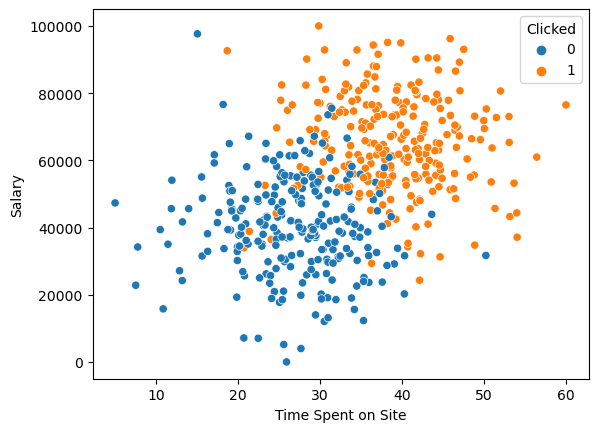

In [4]:
sns.scatterplot(x=df['Time Spent on Site'], y = df.Salary, hue=df.Clicked)

<AxesSubplot:xlabel='Clicked', ylabel='Salary'>

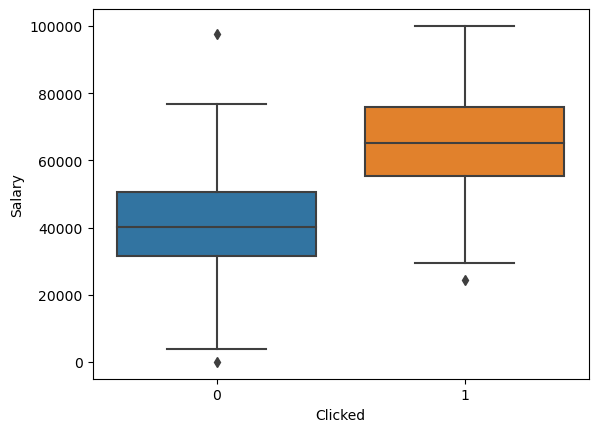

In [5]:
sns.boxplot(x=df.Clicked, y=df.Salary)

# Creating Features And Targets variables and Scaling Them:
---

In [6]:
x = df.drop(columns=['Names','emails','Clicked', 'Country'])
y = df.Clicked

In [7]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x = ss.fit_transform(x)

# Splitting The Data Into Training/Validation Datasets:
---

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x,y, test_size=0.25, random_state=2023)

In [9]:
print(f'x_train shape: {x_train.shape}')
print(f'x_valid shape: {x_valid.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')

x_train shape: (374, 2)
x_valid shape: (125, 2)
y_train shape: (374,)
y_valid shape: (125,)


# Creating The Models:
---
Here I will try several models and pick the best one.

# 1. Logistic Regression:

In [10]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)

LogisticRegression()

<AxesSubplot:>

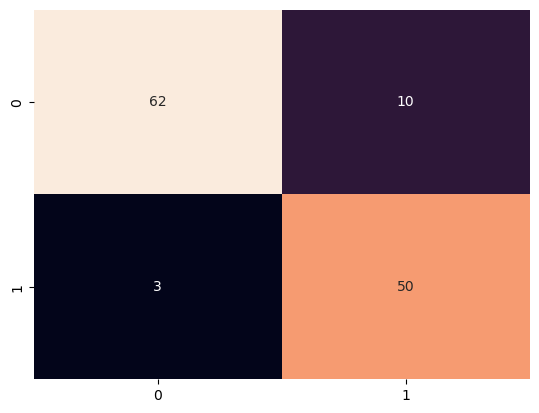

In [11]:
lr_predictions = lr_model.predict(x_valid)
sns.heatmap(confusion_matrix(y_valid, lr_predictions), annot=True, cbar=False)

In [12]:
print(classification_report(y_valid, lr_predictions))

              precision    recall  f1-score   support

           0       0.95      0.86      0.91        72
           1       0.83      0.94      0.88        53

    accuracy                           0.90       125
   macro avg       0.89      0.90      0.90       125
weighted avg       0.90      0.90      0.90       125



# 2. XGBoost:

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
paramaters = {'learning_rate':[0.000001,0.00001,0.0001],
              'booster': ['gbtree', 'gblinear'],
              'lambda':[0.11,0.12,0.13,0.14,0.15]}
              
xgb_model = GridSearchCV(XGBClassifier(),
                         param_grid = paramaters,
                         scoring='accuracy')
xgb_model.fit(x_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan

In [14]:
xgb_model.best_params_

{'booster': 'gblinear', 'lambda': 0.11, 'learning_rate': 1e-06}

<AxesSubplot:>

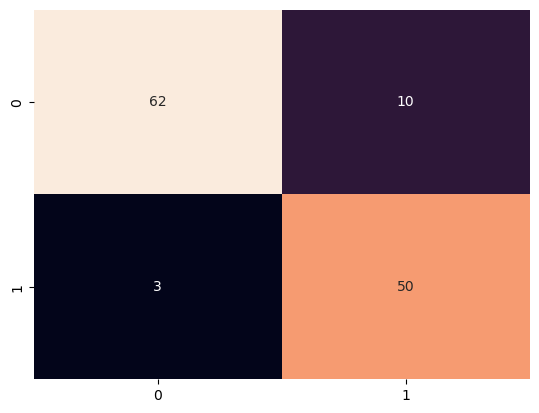

In [15]:
xgb_predictions = xgb_model.predict(x_valid)
sns.heatmap(confusion_matrix(y_valid, xgb_predictions), annot=True, cbar=False)

In [16]:
print(classification_report(y_valid, xgb_predictions))

              precision    recall  f1-score   support

           0       0.95      0.86      0.91        72
           1       0.83      0.94      0.88        53

    accuracy                           0.90       125
   macro avg       0.89      0.90      0.90       125
weighted avg       0.90      0.90      0.90       125



* The two models produce very similar results, hence I will arbitrarly use the XGBoost model.

# Plotting The Decicion Boundray:
---

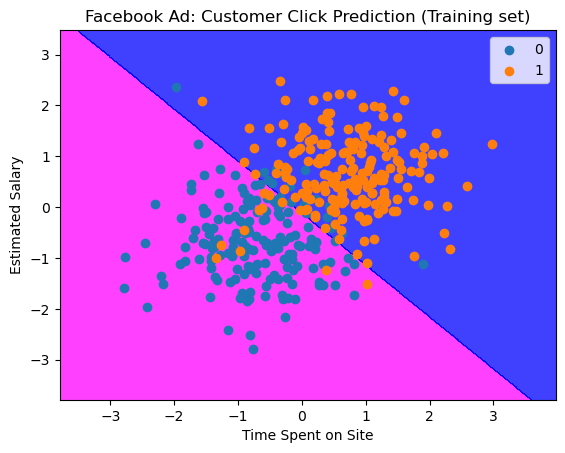

In [17]:
from matplotlib.colors import ListedColormap
X_set, y_set = x_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, xgb_model.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('magenta', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], label = j)
plt.title('Facebook Ad: Customer Click Prediction (Training set)')
plt.xlabel('Time Spent on Site')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()